In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_rel

data = pd.read_csv("gap.tsv", sep='\t')
data.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


# Part 1 Regression analysis of Gapminder data

## Exercise 1
Here, we take the columns year and life expectancy and plot them against eachother

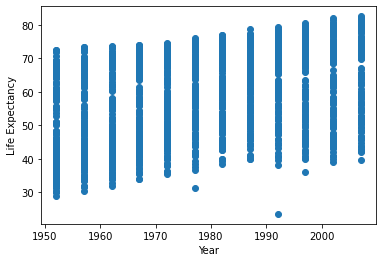

In [103]:
plt.scatter(data['year'],data['lifeExp'])
plt.xlabel('Year')
plt.ylabel('Life Expectancy')

plt.show()

## Question 1
As we can see from the scatter plot above, the general trend seems to point to the fact that life expectancy is increasing as we get closer to the present. The trend looks to be linear, but we will discuss that later on.

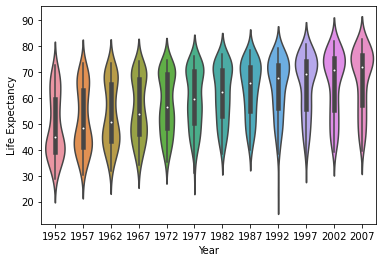

In [104]:
fig, axs = plt.subplots()

sns.violinplot(x='year',y='lifeExp', data=data, widths = 4, ax = axs)
axs.set_xlabel('Year')
axs.set_ylabel('Life Expectancy')

plt.show()

## Question 2
None of the distributions seem to be symmetric at all. For the earlier years, they look roughly positively skewed, whereas the later years seems to be more negatively skewed.

As for the modes of the distributions, it seems as if there are multiple modes for the years 1967 and 1972. The other years appear to have but a single mode.
## Question 3
I would reject the null hypothesis. It is clear that the means are increasing linearly over the years and the modes of the distributions seem to point towards that conclusion as well.
## Question 4
I would expect the violin plot of residuals to be similar to the one above in terms of shape (of the individual distributions), but with different values. 

To be more specific, we would observe the same positive skew in the earlier years with negative values at the head and positive ones at the tail.

The middle few would be relatively symmetric, but not normal.

And the later distributions would be the same as the earlier ones, but flipped. With a negative skew and positive/negative values at the heads/tails, respectively.
## Question 5
According to the assumptions the distributions should be normal with the mean at 0. Everything should be fine, since residuals are only normal if we have a perfect linear regression (mean at 0).
## Exercise 2
First we store the year and lifeExp columns as arrays. Then, we reshape the arrays to make sure that they have the same number of elements. Finally, we use sklearn to find a linear regression of the two arrays.

In [105]:
x = data['year'].values
y = data['lifeExp'].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
lr = linreg().fit(x,y)
print('lifeExp =' + str(lr.coef_[0]), end ='') 
print('*year +' + str(lr.intercept_))

lifeExp =[0.32590383]*year +[-585.65218744]


## Question 6
With each passing year, the life expectancy is expected to increase by .326 years on average.
## Question 7
Again, I don't reject the null. There is a clear relationship between life expectancy and year.
## Exercise 3
Here, we create two new columns representing the predicted value of life expectancy based on year and the residual value based on the predicted value.

Then we simply plot the residual vs year with seaborn.

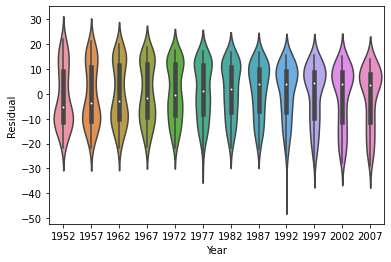

In [106]:
data['predict'] = lr.coef_[0] * data['year'] + lr.intercept_
data['residual'] = data['lifeExp'] - data['predict']

fig, axs = plt.subplots()

sns.violinplot(x='year',y='residual', data=data, widths = 4, ax = axs)
axs.set_xlabel('Year')
axs.set_ylabel('Residual')

plt.show()

## Question 8
This violin plot just about matches what was described in Question 4, except for the middle few distributions, they were not as normal as I had predicted.
## Exercise 4
Here, we just plot the residuals against the continents and plot a violin plot using seaborn.

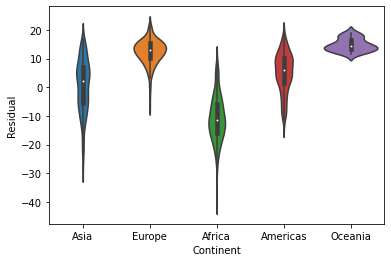

In [107]:
fig, axs = plt.subplots()

sns.violinplot(x='continent',y='residual', data=data, widths = 4, ax = axs)
axs.set_xlabel('Continent')
axs.set_ylabel('Residual')

plt.show()

## Question 9
There seems to be a clear relationship between the two, more specifically, it seems as if life expectancy is dependent on which continent you're looking at. This means that time alone cannot fully explain life expectancy.
## Exercise 5
Now we take the life expectancies of each continent and plot it against the year, giving us a better idea as to how life expectancy has changed over the years for each continent.

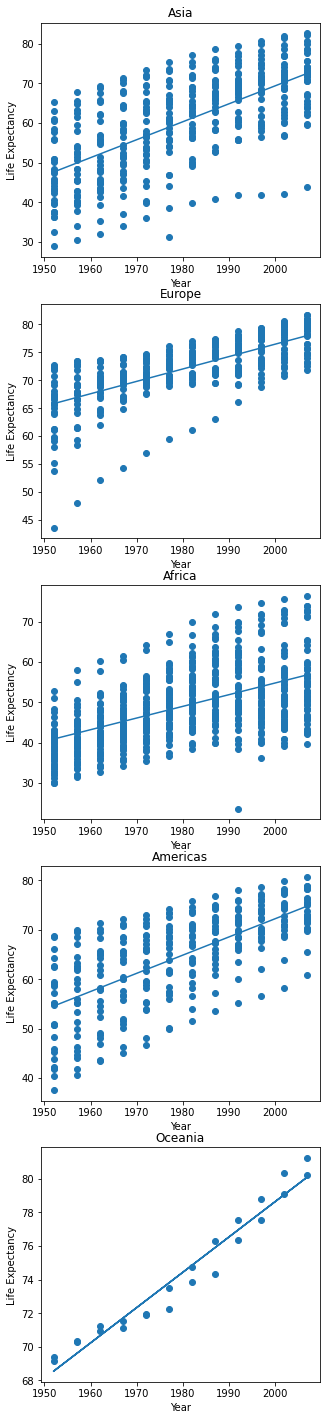

In [108]:
fig, axs = plt.subplots(5, figsize=(5,25))

for i,continent in enumerate(data['continent'].unique()):
    x = data[data.continent == continent]['year']
    y = data[data.continent == continent]['lifeExp']
    axs[i].scatter(x,y)
    axs[i].set_title(continent)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Life Expectancy')
    m,b = np.polyfit(x,y,1)
    axs[i].plot(x,m*x+b)

## Question 10
Based on the 5 plots above, we should include an interaction term for continent and year. Clearly, the life expectancies go up (each year) at different rates for each of the continent that have data. This means that we cannot only rely soley on the year to determine the trend of life expectancies.
## Exercise 6
The interaction variable is Year*Continent. Fitting a linear regression to this variable will show us how much each continent deviates from the overall rate of increase (in terms of life expectancy vs year).



In [109]:
indicator = pd.get_dummies(data['continent'])
data = pd.concat([data,indicator],axis=1)
predictor = ['year','Asia','Europe','Africa','Americas','Oceania','year*Asia','year*Europe','year*Africa','year*Americas','year*Oceania']
for i in range(6,11):
    data[predictor[i]] = data[predictor[i-5]] * data['year']

x = np.array(data[predictor])
y = np.array(data['lifeExp'])

lr = linreg(fit_intercept=False).fit(x,y)

for i,prediction in enumerate(predictor):
    print(prediction + ": " + str(lr.coef_[i]))

year: 0.2570845231944313
Asia: -836.8908952864527
Europe: -367.4109939713075
Africa: -524.2578460693177
Americas: -663.1062932501798
Oceania: -341.90796317028526
year*Asia: 0.19603788070498288
year*Europe: -0.03515237867200443
year*Africa: 0.03244473985054105
year*Americas: 0.11056641386880942
year*Oceania: -0.04681214557226318


If we add the year coefficients and the year*Continent coefficients, we will get the average rates of increase (in life expectancy) for each continent.

In [110]:
for i in range(6,11):
    print(predictor[i-5] + ": " + str(lr.coef_[0] + lr.coef_[i]))

Asia: 0.45312240389941416
Europe: 0.22193214452242688
Africa: 0.28952926304497234
Americas: 0.3676509370632407
Oceania: 0.21027237762216813


## Question 12
On average, life expectancy increases by:

0.453 years in Asia

0.222 years in Europe

0.290 years in Africa

0.368 years in the Americas

0.210 years in Oceania
## Exercise 7
Here, we simply calculate the residuals of based off of the newly added interactions using sklearn's predict function, then plot it against the years in a violin plot.

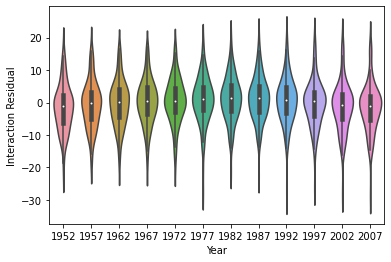

In [111]:
data['predict_res'] = lr.predict(x)
data['residual_res'] = data['lifeExp'] - data['predict_res']

fig, axs = plt.subplots()

sns.violinplot(x='year',y='residual_res', data=data, widths = 4, ax = axs)
axs.set_xlabel('Year')
axs.set_ylabel('Interaction Residual')

plt.show()

This time the residuals vs time violin plot matches much better with our assumptions of what a linear regression should look like. Both normal and mean centered at (close to) 0.

# Part 2: Classification
From here on out we will be using the wine dataset provided by sklearn.

Our goal is to train a model using an algorithm that will allow us to predict the class of a given wine sample based on 13 attributes of that wine sample (ie. alcohol %, magnesium levels, hue, etc.).

We will run the Linear Discriminant Analysis algorithm and the linear SVM algorithm on the wine dataset to produce two models. Then, we will compare the accuracies of the two models to see which algorithm performed better on the wine dataset.

Here we see that there are a total of 178 wine samples at our disposals and 13 parameters for us to play with.

In [118]:
X,y = datasets.load_wine(return_X_y=True)
X.shape,y.shape

((178, 13), (178,))

First we will run the linear SVM on the dataset, using 10-fold cross validation to determine the accuracy of the model. For the hyper-parameters (just C in our case), I just kept fiddling with it to get the best performance out of the algoirthm.

In [113]:
lin_SVM = svm.SVC(kernel='linear', C=1.46)
scores1= cross_val_score(lin_SVM, X, y, scoring='accuracy', cv=10)
scores1.mean(), scores1.std()

(0.961111111111111, 0.04339027597725921)

Next, we will run the linear discriminant analysis (LDA) on the dataset, again, using 10-fold cross validation to determine the accuracy of the model.

In [114]:
LDA = LinearDiscriminantAnalysis()
scores2 = cross_val_score(LDA, X, y, scoring='accuracy', cv=10)
scores2.mean(), scores2.std()

(0.9774509803921569, 0.02763129388748755)

While both algorithms produced excellent results, it seems (to me) as if LDA is simply better for this given dataset.

For LDA outperformed linear SVM in both accuracy (by the mean score) and consistancy (by the standard deviation score).

Next we will run a paired t-test on the two model performances to see if the difference is (statistically) significant or not. We will do this by using the scipy.stats module.

In [117]:
ttest_rel(scores1,scores2)

Ttest_relResult(statistic=-0.9710823024970476, pvalue=0.3568802128018751)

Seeing that our p-value is (well) above 5%, we can come to the conclusion that there is no (statistical) significance in whether we choose LDA or linear SVM. Both will perform (statistically) similar for the wine dataset.